## Clean Wikipedia Data

In [163]:
# import libraries
import pandas as pd

In [164]:
# grab table from Wikipedia page
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]

# only keep where borough is available 
df = df[df['Borough']!='Not assigned']

# replace neighbourhood as borough if neighbourhood is not availble - there are no instances of this but code here anwyay
df['Neighbourhood'].replace('Not assigned', df['Borough'], inplace=True)
df.shape

# combine neighborhoods in the same postal code - already done in the data
# df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].transform(lambda x: ','.join(x))
# df.drop_duplicates()
# df

(103, 3)

## Get Postal Code Long/Lat

In [57]:
# can't get geocode to work -- switched to csv

In [165]:
# read in csv file
latlongs = pd.read_csv('Geospatial_Coordinates.csv')
latlongs

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [166]:
# merge latlongs lookup on to main data
df2 = df.merge(latlongs, left_on='Postal Code', right_on='Postal Code')
df2

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


## Segment and Cluster Toronto Neighborhoods

In [167]:
# import libraries
import folium
from sklearn.cluster import KMeans
import numpy as np

In [188]:
# map all boroughs

# define function
def make_map(df, start_lat, start_long, zoom_start):
    m = folium.Map(location=[start_lat, start_long], zoom_start=zoom_start)
    for lat, long, label in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, long],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7, 
            parse_html=False).add_to(m)
    return m
    
start_lat = 43.6532
start_long = -79.3832
zoom_start = 10
map_all = make_map(df2, start_lat, start_long, zoom_start)
map_all

In [189]:
# map only toronto boroughs
toronto_df = df2[df2['Borough'].str.contains('Toronto')].reset_index()
map_toronto = make_map(toronto_df,start_lat, start_long, 11)
map_toronto

In [170]:
# will just cluster bouroughs that contain the word "Toronto"
# imports
import requests
import json

In [171]:
# define FourSquare credentials
CLIENT_ID = 'YL4F00KRM2ATGYXNWMXR1FGN45UF0LTMGCSSNXSKQYXHJN5E' # your Foursquare ID
CLIENT_SECRET = 'OZB2DVDSN3SLHKJUOND3EIQL1UYSHZT1P0P0PJUHI2FZNWKD' # your Foursquare Secret
VERSION = '20180605'# Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YL4F00KRM2ATGYXNWMXR1FGN45UF0LTMGCSSNXSKQYXHJN5E
CLIENT_SECRET:OZB2DVDSN3SLHKJUOND3EIQL1UYSHZT1P0P0PJUHI2FZNWKD


In [172]:
# get nearby places function
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [173]:
# call nearby venues function
nearby_venues_df = getNearbyVenues(toronto_df['Neighbourhood'], toronto_df['Latitude'], toronto_df['Longitude'], radius=500)
nearby_venues_df.head()

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [109]:
# check how many venues returned by neighborhood
nearby_venues_df.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,54,54,54,54,54,54
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",13,13,13,13,13,13
Central Bay Street,61,61,61,61,61,61
Christie,16,16,16,16,16,16
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34


In [174]:
# find unique categories
print('There are {} uniques categories.'.format(len(nearby_venues_df['Venue Category'].unique())))

There are 233 uniques categories.


In [175]:
# analyze each neighborhood

# one hot encoding
toronto_onehot = pd.get_dummies(nearby_venues_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = nearby_venues_df['Neighborhood'] 

# group rows by neighborhood and take mean of the frequency of occureence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean()
toronto_grouped

,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.000000,0.00000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000
"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",0.000000,0.055556,0.055556,0.055556,0.111111,0.166667,0.111111,0.000000,0.000000,0.00,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.000000,0.00000,0.00,0.016393,0.000000,0.000000,0.016393,0.016393
Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
Church and Wellesley,0.012658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.00,...,0.012658,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.025316
"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,...,0.000000,0.00000,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000
Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00000,0.027778,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [176]:
# function to find most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [192]:
# display top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped.index

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Beer Bar,Farmers Market,Seafood Restaurant,Bakery,Cheese Shop,Pharmacy,Sporting Goods Shop
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Gym,Furniture / Home Store,Intersection,Bar,Restaurant,Bakery,Climbing Gym
2,"Business reply mail Processing Centre, South C...",Pizza Place,Auto Workshop,Brewery,Light Rail Station,Park,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Bar,Harbor / Marina,Coffee Shop,Rental Car Location,Sculpture Garden,Boutique
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Burger Joint,Bubble Tea Shop,Salad Place,Yoga Studio,Spa,Department Store


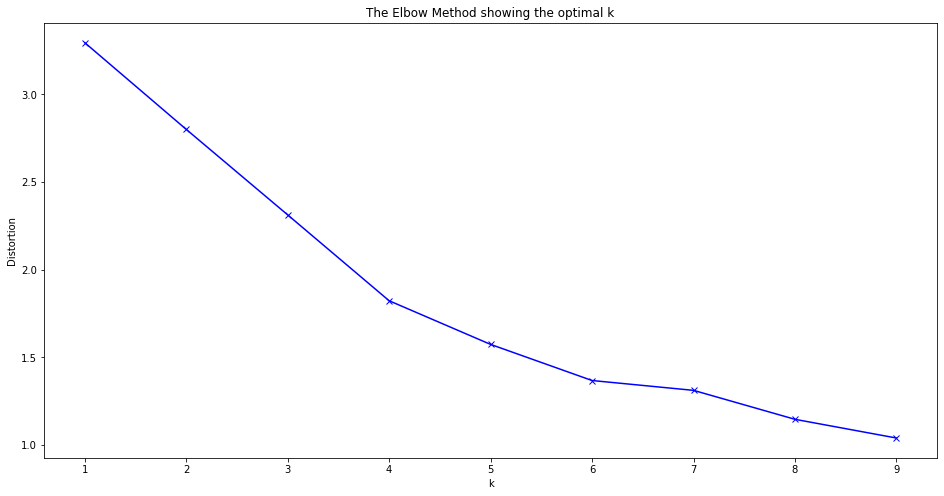

In [201]:
## clustering

# find optimal k with elbow plot method
distortions = []
K = range(1,10)

for k_clusters in K:
    kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(toronto_grouped)
    distortions.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [202]:
# 4 clusters in optimal
kmeans = KMeans(n_clusters=4, random_state=0).fit(toronto_grouped)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0,
       0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0], dtype=int32)

In [203]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_df.rename(columns={'Neighbourhood':'Neighborhood'})

# merge toronto_grouped with toronto_df to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,index,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Theater,Mexican Restaurant,Dessert Shop
1,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Diner,Portuguese Restaurant,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Fried Chicken Joint
2,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Italian Restaurant,Bubble Tea Shop,Café,Middle Eastern Restaurant,Cosmetics Shop,Japanese Restaurant,Ramen Restaurant,Hotel
3,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Gym,Italian Restaurant,Restaurant,Clothing Store,Moroccan Restaurant
4,19,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Pub,Park,Trail,Health Food Store,Yoga Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run


In [212]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[start_lat, start_long], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


In [206]:
## examine clusters

# cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,-79.360636,0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Restaurant,Café,Theater,Mexican Restaurant,Dessert Shop
1,M7A,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Diner,Portuguese Restaurant,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Fried Chicken Joint
2,M5B,-79.378937,0,Clothing Store,Coffee Shop,Italian Restaurant,Bubble Tea Shop,Café,Middle Eastern Restaurant,Cosmetics Shop,Japanese Restaurant,Ramen Restaurant,Hotel
3,M5C,-79.375418,0,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Gym,Italian Restaurant,Restaurant,Clothing Store,Moroccan Restaurant
5,M5E,-79.373306,0,Coffee Shop,Cocktail Bar,Restaurant,Beer Bar,Farmers Market,Seafood Restaurant,Bakery,Cheese Shop,Pharmacy,Sporting Goods Shop
6,M5G,-79.387383,0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Burger Joint,Bubble Tea Shop,Salad Place,Yoga Studio,Spa,Department Store
7,M6G,-79.422564,0,Grocery Store,Café,Park,Restaurant,Baby Store,Athletics & Sports,Italian Restaurant,Nightclub,Candy Store,Coffee Shop
8,M5H,-79.384568,0,Coffee Shop,Café,Restaurant,Gym,Deli / Bodega,Clothing Store,Thai Restaurant,Concert Hall,Salad Place,Bookstore
9,M6H,-79.442259,0,Pharmacy,Bakery,Music Venue,Bank,Supermarket,Middle Eastern Restaurant,Café,Pool,Furniture / Home Store,Smoke Shop
10,M5J,-79.381752,0,Coffee Shop,Aquarium,Hotel,Café,Fried Chicken Joint,Restaurant,Brewery,Scenic Lookout,Italian Restaurant,Music Venue


In [207]:
# cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,M4T,-79.38316,1,Summer Camp,Restaurant,Yoga Studio,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [208]:
# cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,M5N,-79.416936,2,Home Service,Garden,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [209]:
# cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,M4E,-79.293031,3,Pub,Park,Trail,Health Food Store,Yoga Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run
18,M4N,-79.388790,3,Park,Swim School,Bus Line,Yoga Studio,Dessert Shop,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
33,M4W,-79.377529,3,Park,Playground,Trail,Yoga Studio,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
